# E-7. Sentiment Classification of Moview Review Comments (Good, Bad)

## Data Description

### Each file is consisted of three columns: id, document, label

- id: The review id, provieded by Naver
- document: The actual review
- label: The sentiment class of the review. (0: negative, 1: positive)
- Columns are delimited with tabs (i.e., .tsv format; but the file extension is .txt for easy access for novices)

### 200K reviews in total
- ratings.txt: All 200K reviews
- ratings_test.txt: 50K reviews held out for testing
- ratings_train.txt: 150K reviews for training

In [43]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()
#test_data.head()
print(train_data.shape, test_data.shape)


(150000, 3) (50000, 3)


In [44]:
test_data.drop_duplicates('document')
test_data.shape

(50000, 3)

## 1. Preprocessing
데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [45]:
tokenizer = Mecab() #형태소 분석기 중 하나
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)



In [46]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

In [47]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

1)데이터셋 내 문장 길이 분포

2)적절한 최대 문장 길이 지정

3)keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

the proper maximum length is 41!


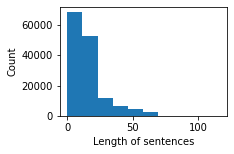

In [48]:
#index_list=X_train+X_test
#len(index_list)
len_list=list(map(len,X_train))
num_tokens = np.array(len_list)


plt.figure(figsize=(3,2))
plt.hist(len_list)
plt.xlabel('Length of sentences')
plt.ylabel('Count')

print('the proper maximum length is 41!')


In [49]:
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

print('the proper maximum length is 41!')

문장길이 평균 :  15.981694052619337
문장길이 최대 :  116
문장길이 표준편차 :  12.824740844757251
pad_sequences maxlen :  41
전체 문장의 0.9341711017772366%가 maxlen 설정값 이내에 포함됩니다. 
the proper maximum length is 41!


In [50]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'post'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'post'
                                                       maxlen=maxlen)



In [51]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 4. 모델구성 및 validation set 구성

1) RNN(LSTM layer)
2) Conv1D
3) GlobalMaxPooling2D

1) RNN(LSTM layer)

In [52]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model1 = keras.Sequential()
# [[YOUR CODE]]
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(keras.layers.Dense(8, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid')) 
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


2) Conv1D


In [53]:


model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.MaxPooling1D(5))
model2.add(keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

3) GlobalMaxPooling2D

In [54]:


model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


In [55]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 5. Model training

In [56]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history1 = model1.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 11ms/step - loss: 0.6053 - accuracy: 0.6591 - val_loss: 0.3604 - val_accuracy: 0.8440
Epoch 2/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3404 - accuracy: 0.8581 - val_loss: 0.3360 - val_accuracy: 0.8537
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3086 - accuracy: 0.8733 - val_loss: 0.3332 - val_accuracy: 0.8536
Epoch 4/10
266/266 [==============================] - 3s 9ms/step - loss: 0.2937 - accuracy: 0.8785 - val_loss: 0.3338 - val_accuracy: 0.8573
Epoch 5/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2790 - accuracy: 0.8872 - val_loss: 0.3366 - val_accuracy: 0.8573
Epoch 6/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2633 - accuracy: 0.8931 - val_loss: 0.3367 - val_accuracy: 0.8557
Epoch 7/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2538 - accuracy: 0.8987 - val_loss: 0.3469 - val_accuracy: 0.8558
Epoch

In [57]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1
                )

Epoch 1/10
266/266 [==============================] - 3s 8ms/step - loss: 0.5792 - accuracy: 0.6838 - val_loss: 0.3492 - val_accuracy: 0.8460
Epoch 2/10
266/266 [==============================] - 2s 7ms/step - loss: 0.3244 - accuracy: 0.8625 - val_loss: 0.3348 - val_accuracy: 0.8537
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2873 - accuracy: 0.8816 - val_loss: 0.3321 - val_accuracy: 0.8549
Epoch 4/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2604 - accuracy: 0.8943 - val_loss: 0.3349 - val_accuracy: 0.8556
Epoch 5/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2266 - accuracy: 0.9123 - val_loss: 0.3505 - val_accuracy: 0.8532
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1958 - accuracy: 0.9276 - val_loss: 0.3755 - val_accuracy: 0.8520
Epoch 7/10
266/266 [==============================] - 2s 7ms/step - loss: 0.1641 - accuracy: 0.9419 - val_loss: 0.4091 - val_accuracy: 0.8472
Epoch 

In [58]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.6497 - accuracy: 0.6751 - val_loss: 0.4066 - val_accuracy: 0.8279
Epoch 2/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3805 - accuracy: 0.8400 - val_loss: 0.3503 - val_accuracy: 0.8432
Epoch 3/10
266/266 [==============================] - 1s 4ms/step - loss: 0.3208 - accuracy: 0.8643 - val_loss: 0.3421 - val_accuracy: 0.8470
Epoch 4/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2951 - accuracy: 0.8777 - val_loss: 0.3436 - val_accuracy: 0.8466
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2750 - accuracy: 0.8866 - val_loss: 0.3480 - val_accuracy: 0.8485
Epoch 6/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2576 - accuracy: 0.8959 - val_loss: 0.3533 - val_accuracy: 0.8482
Epoch 7/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2459 - accuracy: 0.9016 - val_loss: 0.3601 - val_accuracy: 0.8498
Epoch 

## 6. visualization of Loss, and accuracy

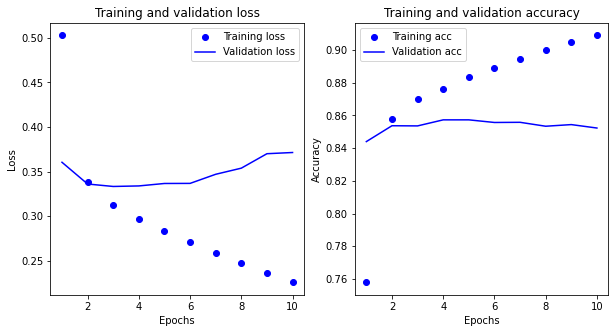

In [59]:
history_dict = history1.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss') # training loss 시각화
plt.plot(epochs, val_loss, 'b', label='Validation loss')# valloss 시각화

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

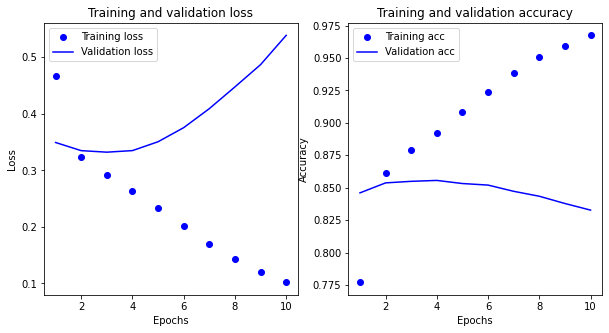

In [60]:
history_dict = history2.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss') # training loss 시각화
plt.plot(epochs, val_loss, 'b', label='Validation loss')# valloss 시각화

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

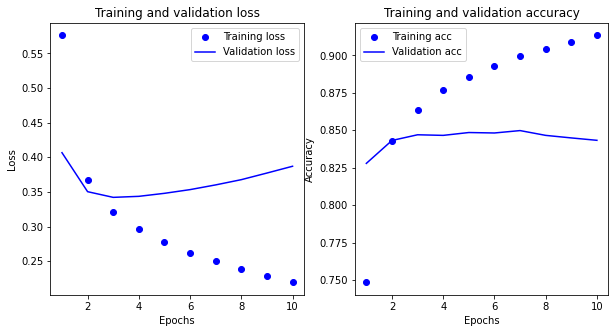

In [61]:
history_dict = history3.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, loss, 'bo', label='Training loss') # training loss 시각화
plt.plot(epochs, val_loss, 'b', label='Validation loss')# valloss 시각화

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Evaluating Model

In [74]:
# LSTM
print("LSTM")
results_lstm = model1.evaluate(X_test, y_test, verbose=2)
print(results_lstm)
print("-------------------------------------------------------------------------")

# 1-D CNN
print("1-D CNN")
results_cnn = model2.evaluate(X_test, y_test, verbose=2)
print(results_cnn)
print("-------------------------------------------------------------------------")

# GlobalAveragePooling1D
print("GlobalAveragePooling1D layer")
results_simple = model3.evaluate(X_test, y_test, verbose=2)
print(results_simple)

LSTM
1537/1537 - 5s - loss: 0.3825 - accuracy: 0.8458
[0.3824889659881592, 0.8457595109939575]
-------------------------------------------------------------------------
1-D CNN
1537/1537 - 2s - loss: 0.5466 - accuracy: 0.8323
[0.5465524196624756, 0.8322924375534058]
-------------------------------------------------------------------------
GlobalAveragePooling1D layer
1537/1537 - 2s - loss: 0.4079 - accuracy: 0.8373
[0.40791308879852295, 0.8372968435287476]


## -> LSTM is the best of the three

## 7. Analyzing the Embedding Layer

In [62]:
embedding_lstm = model1.layers[0]
weights_lstm = embedding_lstm.get_weights()[0]

embedding_cnn = model2.layers[0]
weights_cnn = embedding_cnn.get_weights()[0]

embedding_simple = model3.layers[0]
weights_simple = embedding_simple.get_weights()[0]

print(weights_lstm.shape,weights_cnn.shape, weights_simple.shape )

(10000, 16) (10000, 16) (10000, 16)


### Word2vec file of 3 models

In [63]:
import os
word2vec_file_path_lstm = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model1.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [64]:
word2vec_file_path_cnn = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model2.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [65]:
word2vec_file_path_simple = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_simple.txt'
f = open(word2vec_file_path_simple, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = model3.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

## 8.improve the performance by using Word2Vec Embedding

Korean Word2Vec:
https://github.com/Kyubyong/wordvectors

In [66]:
path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = Word2Vec.load(path)
vector = word2vec['배우']
vector.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(200,)

In [67]:
print(word2vec.most_similar('배우'))

[('가르치', 0.7075916528701782), ('익히', 0.5947338938713074), ('공부', 0.5693216919898987), ('영화배우', 0.523245096206665), ('연출가', 0.509418249130249), ('후배', 0.49829238653182983), ('연극배우', 0.47326865792274475), ('연마', 0.4723285734653473), ('선보이', 0.471835732460022), ('무용가', 0.46976548433303833)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


In [68]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [79]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 




# model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(keras.layers.Dense(8, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid')) 


model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [80]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 8s 27ms/step - loss: 0.5996 - accuracy: 0.6619 - val_loss: 0.4288 - val_accuracy: 0.8022
Epoch 2/10
266/266 [==============================] - 7s 27ms/step - loss: 0.3908 - accuracy: 0.8238 - val_loss: 0.3650 - val_accuracy: 0.8397
Epoch 3/10
266/266 [==============================] - 7s 26ms/step - loss: 0.3241 - accuracy: 0.8611 - val_loss: 0.3450 - val_accuracy: 0.8482
Epoch 4/10
266/266 [==============================] - 7s 26ms/step - loss: 0.2883 - accuracy: 0.8809 - val_loss: 0.3424 - val_accuracy: 0.8505
Epoch 5/10
266/266 [==============================] - 7s 25ms/step - loss: 0.2592 - accuracy: 0.8967 - val_loss: 0.3482 - val_accuracy: 0.8502
Epoch 6/10
266/266 [==============================] - 7s 25ms/step - loss: 0.2356 - accuracy: 0.9074 - val_loss: 0.3615 - val_accuracy: 0.8501
Epoch 7/10
266/266 [==============================] - 6s 24ms/step - loss: 0.2113 - accuracy: 0.9194 - val_loss: 0.3732 - val_accuracy: 0.8482

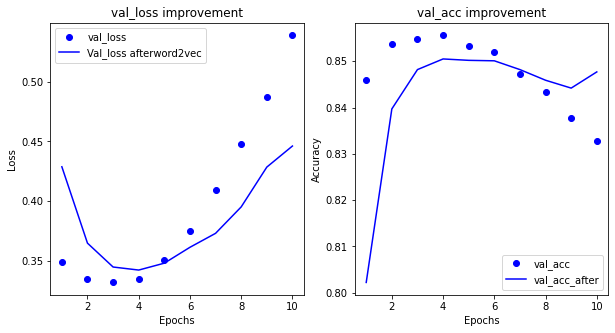

In [81]:
history_dict= history2.history
history_dict_after = history.history


#acc1 = history_dict['accuracy']
val_acc1 = history_dict['val_accuracy']
#loss1 = history_dict['loss']
val_loss1 = history_dict['val_loss']

# word2vec 활용 후 loss
#acc2 = history_dict_after['accuracy']
val_acc2 = history_dict_after['val_accuracy']
#loss2 = history_dict_after['loss']
val_loss2 = history_dict_after['val_loss']


epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(epochs, val_loss1, 'bo', label='val_loss') # training loss 시각화
plt.plot(epochs, val_loss2, 'b', label='Val_loss afterword2vec')# valloss 시각화

plt.title('val_loss improvement')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, val_acc1, 'bo', label='val_acc')
plt.plot(epochs, val_acc2, 'b', label='val_acc_after')
plt.title('val_acc improvement')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## better val_loss and val_acc after word2vec

In [82]:
# 테스트셋을 통한 모델 평가
results_before = model2.evaluate(X_test,  y_test, verbose=2)
results_after = model.evaluate(X_test,  y_test, verbose=2)
print(results_before)
print(results_after)

1537/1537 - 2s - loss: 0.5466 - accuracy: 0.8323
1537/1537 - 3s - loss: 0.4650 - accuracy: 0.8411
[0.5465524196624756, 0.8322924375534058]
[0.46504777669906616, 0.8410602807998657]


### Loss diminished by 0.08, and accuracy by 0.01 in testset

## Retrospect

1) LSTM layer was the best of the three model

2) Conv1D model experienced improvement in performace after using **word2vec** embedding matrix

3) LSTM model did not experienced big change in performance in the same situation

4) Hyperparameter change is needed for optimization